In [1]:
%matplotlib inline

import numpy as np

from scipy.linalg import solve_toeplitz, toeplitz
from numpy.linalg import solve

from matplotlib import pyplot as plt

Let's start with some definitions. We have a time series dataset consisting of $N$ samples:

$$
\mathbf{x} = \{x_1, x_2, \dots, x_N\}.
$$

In the case where we need to perform interpolation, the samples $\{x_1, \dots, x_m\}$ and $\{x_{m+k+1}, \dots, x_N\}$ are known, while there are $k$ missing samples $\{x_{m+1}, \dots, x_{m+k}\}$. We can call the known samples:

$$
\mathbf{y} = \{x_1, \dots, x_m, x_{m+k+1}, x_N\},
$$

and the missing samples:

$$
\mathbf{z} = \{x_{m+1}, \dots, x_{m+k}\}.
$$

The samples are assumed to be produced by some [autoregressive process](https://en.wikipedia.org/wiki/Autoregressive_model) given by:

$$
x_{i} = \left(\sum_{j=1}^{p} \theta_j x_{i-j}\right) + e_i, 
$$

where $p$ is the order of the autoregressive mode, $\theta$ are the parameters that define the model and $e_i$ is some additive (stationary, white, Gaussian) noise.

## The likelihood

Given data consisting of the set of known samples $\mathbf{y}$ and the generative model for the samples

$$
a_i(\mathbf{x}, p, \vec{\theta}) = \sum_{j=1}^{p} \theta_j x_{i-j}, 
$$

we want to be able to infer a the values of a set missing samples $\mathbf{z}$ (assumed to be a continguous set within $\mathbf{x}$ bounded on other side by the observations in $\mathbf{y}$) and the unknown autoregression parameters $\vec{\theta}$. In other words we want to interpolate over the gap in $\mathbf{y}$. In the context of interpolation, the actual values of the parameters $\vec{\theta}$ are unimportant.

For this inference, we need to known the likelihood of the observed data given the unknown parameters. In our model we assume that the noise in the data is drawn from a white Gaussian stationary process with a standard deviation of $\sigma$, so the likelihood can be written as

$$
p(\mathbf{y}|\mathbf{z}, \vec{\theta}, \sigma) \propto \exp{\left(-\frac{1}{2\sigma^2} \sum_{i=1}^N \left(x_i - a_i(\mathbf{x}, p, \vec{\theta})^2\right) \right)},
$$

where $\mathbf{x}$ is as defined above. This can be written more generally in vector and matrix form as

$$
p(\mathbf{y}|\mathbf{z}, \vec{\theta}, \sigma) \propto \exp{\left(-\frac{1}{2}(\mathbf{x} - \mathbf{L}\vec{\theta})^T\Sigma^{-1}(\mathbf{x} - \mathbf{L}\vec{\theta})\right)},
$$

where the terms in the exponent

$$
\mathbf{e} = \mathbf{x} - \mathbf{L}\vec{\theta},
$$

can be written out (removing the $p$ initial points from the vector $\mathbf{x}$, which are required to produce the $(p+1)^{\rm th}$ point) as

$$
\left[\begin{array}{c}e_{p+1} \\ e_{p+2} \\ e_{p+3} \\ \vdots \\ e_{N-2} \\ e_{N-1} \\ e_{N}\end{array}\right] = \left[\begin{array}{c}x_{p+1} \\ x_{p+2} \\ x_{p+3} \\ \vdots \\ x_{N-2} \\ x_{N-1} \\ x_{N}\end{array}\right] - 
\left[\begin{array}{cccc}
x_{p} & x_{p-1} & \ldots & x_1 \\
x_{p+1} & x_{p} & \ldots & x_2 \\
x_{p+2} & x_{p+1} & \ldots & x_3 \\
\vdots & \vdots & \vdots & \vdots \\
x_{N-3} & x_{N-4} & \ldots & x_{N-2-p} \\
x_{N-2} & x_{N-3} & \ldots & x_{N-1-p} \\
x_{N-1} & x_{N-2} & \ldots & x_{N-p}
\end{array}\right]
\left[\begin{array}{c}\theta_1 \\ \vdots \\ \theta_p\end{array}\right],
$$

and $\Sigma$ is the covariance matrix, which in this can is a purely diagonal matrix consisting of $1/\sigma^2$.

Alternatively, the likelihood could be written in the form

$$
p(\mathbf{y}|\mathbf{z}, \vec{\theta}, \sigma) \propto \exp{\left(-\frac{\mathbf{x}^T \mathbf{K}^T \mathbf{K} \mathbf{x}}{2\sigma^2}\right)},
$$

where the terms in the exponent

$$
\mathbf{e} = \mathbf{K}\mathbf{x},
$$

where in this case we assume that the unobserved data prior to $x_1$ is zero, and can be written out as

$$
\left[
\begin{array}{c}
e_1 \\ e_2 \\ e_3 \\ e_4 \\ \vdots \\ e_{N-3} \\ e_{N-2} \\ e_{N-1} \\ e_N \end{array}
\right] = 
\left[
\begin{array}{ccccccccc}
1 & 0 & 0 & 0 & \ldots & 0 & 0 & 0 & 0 \\
-\theta_1 & 1 & 0 & 0 & \ldots & 0 & 0 & 0 & 0 \\
-\theta_2 & -\theta_1 & 1 & 0 & \ldots & 0 & 0 & 0 & 0 \\
-\theta_3 & -\theta_2 & -\theta_1 & 1 & \ldots & 0 & 0 & 0 & 0 \\
& & & & \ddots & & & & \\
0 & 0 & 0 & 0 & \ldots & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & \ldots & -\theta_1 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & \ldots & -\theta_2 & -\theta_1 & 1 & 0 \\
0 & 0 & 0 & 0 & \ldots & -\theta_3 &-\theta_2 & -\theta_1 & 1 \\
\end{array}
\right]
\left[
\begin{array}{c}
x_1 \\ x_2 \\ x_3 \\ x_4 \\ \vdots \\ x_{N-3} \\ x_{N-2} \\ x_{N-1} \\ x_N \end{array}
\right].
$$

Here $\mathbf{K}$ is a [Toeplitz matrix](https://en.wikipedia.org/wiki/Toeplitz_matrix), i.e., all the diagonal's from left to right have the same value. If we incorporated $1/\sigma^2$ into $\mathbf{K}^T \mathbf{K}$ it would be the inverse of the covariance matrix $\Sigma^{-1}$, e.g.,

$$
p(\mathbf{y}|\mathbf{z}, \vec{\theta}, \sigma) \propto \exp{\left(-\frac{\mathbf{x}^T \Sigma^{-1} \mathbf{x}}{2}\right)}.
$$

In this form the covariance matrix is not longer purely diagonal, but now shows how the data is correlated by the autoregression model.

## Gibbs sampling

Our aim is to find the posterior distribution on the unknown samples $\mathbf{z}$, autogression parameters $\vec{\theta}$, and noise standard deviation $\sigma$, so we need to set priors on these to convert the likelihood into a posterior. We will assume flat priors on all parameters (including $\sigma$, although a log-uniform prior might be more appropriate in that case), so we have

$$
p(\mathbf{z}, \vec{\theta}, \sigma| \mathbf{y}) \propto p(\mathbf{y}|\mathbf{z}, \vec{\theta}, \sigma).
$$

One way to sample from this posterior distribution is to use the Gibbs sampler. This requires the ability to calculate conditional distributions for each (set of) parameter(s) from which those parameters can be drawn in turn. For example the conditional distribution on $\mathbf{z}$, given $\vec{\theta}$ and $\sigma$ would be written

$$
p(\mathbf{z}| \vec{\theta}, \sigma, \mathbf{y}) = \frac{p(\mathbf{z}, \vec{\theta}, \sigma| \mathbf{y})}{p(\vec{\theta}, \sigma|\mathbf{y})}.
$$

As $\vec{\theta}$ and $\sigma$ are assumed to be known in this conditional distribution, the denominator is just a constant and we have

$$
p(\mathbf{z}| \vec{\theta}, \sigma, \mathbf{y}) \propto p(\mathbf{z}, \vec{\theta}, \sigma| \mathbf{y}).
$$

Given that the posterior is proportional to the likelihood, we know that the conditional distributions for values of $\mathbf{z}$ and $\vec{\theta}$ will be multivariate Gaussian distributions. The means and covariances of these multivariate Gaussian distributions can be calculated and subsequently values can be drawn from them.

For the Gibbs sampler, we can first draw a set of missing samples $\mathbf{z}'$. The conditional distribution from which we can draw these is a multivariate Gaussian with an inverse covariance matrix given by:

$$
\mathbf{C}^{-1} = \frac{\mathbf{D}}{\sigma^2},
$$

where $\sigma$ is an estimate of the standard deviation of the noise in the autoregressive model and $\mathbf{D}$ is a submatrix of $\mathbf{K}^T \mathbf{K}$ corresponding to the missing data vector $z$, i.e., it will be the matrix within $\mathbf{K}^T \mathbf{K}$ from rows $m+1 \rightarrow m+k$ and columns $m+1 \rightarrow m+k$. The mean of the multivariate Gaussian is given by:

$$
\mu = -\mathbf{D}^{-1}\mathbf{B}^T\mathbf{y},
$$

where $\mathbf{B}$ is composed of the submatrices of $\mathbf{K}^T \mathbf{K}$ corresponding to the columns $m+1 \rightarrow m+k$ and the rows from $1 \rightarrow m$ and $m + k + 1 \rightarrow N$.

In [72]:
def Kmatrix(theta, N):
    """
    Function to create the NxN Toeplitz array K.
    
    Parameters
    ----------
    theta: array_like
        The set of autorgression parameters.
    N: int
        The length of the data set.
    
    Returns
    -------
    K: ndarray
        The NxN Toeplitz array
    """
    
    # create top row
    r = np.zeros(N)
    r[0] = 1.0
    
    # create first column
    c = np.zeros(N)
    c[0] = 1.0
    c[1:len(theta) + 1] = -theta

    return toeplitz(c, r=r)


def Dmatrix(ktk, m, k):
    """
    Get the submatrix of ktk corresponding to the rows and columns
    from m to m+k.
    """
    
    return ktk[m - 1:m + k - 1, m - 1:m + k - 1]


def Bmatrix(ktk, m, k):
    """
    Get the submatrix of ktk corresponing to the columns from m to
    m+k and the rows 1 to m and m+k to N where N is the height of
    the array.
    """
    
    return np.hstack((ktk[m - 1:m + k - 1, :m - 1], ktk[m - 1:m + k - 1, m + k - 1:])).T


def draw_conditional_z(theta, sigma, y, m, k, rng=None):
    """
    Draw the missing data, z, from the conditional distribution based
    on estimates of the autoregressive parameters and the noise.
    
    Parameters
    ----------
    theta: array_like
        The set of p autoregressive parameters
    sigma: float
        The noise standard deviation
    y: array_like
        The observed data.
    m: int
        The index giving the start of the missing samples (starting
        from 1).
    k: int
        The number of missing samples
    rng: default_rng
        The Numpy default random number generator
        
    Returns
    -------
    z: array_like
        An set of k missing samples.
    """
    
    # total length of data
    N = len(y) + k
    
    # create K matrix
    K = Kmatrix(theta, N)
    
    # calculate K^T K
    KTK = np.dot(K.T, K)
    
    # get the B and D submatrices of KTK
    B = Bmatrix(KTK, m, k)
    D = Dmatrix(KTK, m, k)

    # inverse of D
    invD = np.linalg.inv(D)
    
    # get the covariance matrix of the multivariate Gaussian
    cov = sigma**2 * invD

    # get the mean of the multivariate Gaussian
    mu = -np.dot(invD, np.dot(B.T, y))
    
    if rng is None:
        rng = np.random.default_rng()
    
    return rng.multivariate_normal(mu, cov, method="cholesky")

In [68]:
def Lmatrix(x, p, full=True):
    """
    The matrix of data given a set certain autogressive order p.
    
    Parameters
    ----------
    x: array_like
        The array of data points
    p: int
        The order of the autoregressive model
    full: book
        If True this will pad the matrix with zeros appropriately.
    """
    
    #L = np.zeros((len(x) - p, p))
    
    #for i in range(p):
    #    L[:, i] = x[p-1-i:-(i+1)]

    if full:
        c = np.zeros(len(x) + p)
        c[1:len(x) + 1] = x
        r = np.zeros(p)
    else:
        c = x[p - 1:-1]
        r = x[p - 1::-1]

    # using Toeplitz, which is quicker when x and p get large.
    L = toeplitz(c, r=r)

    return L


def draw_conditional_theta(x, sigma, p, rng=None):
    """
    Draw from the conditional distribution of the autoregressive
    parameters.
    
    Parameters
    ----------
    x: array_like
        The array of data samples (observed and missing)
    sigma: float
        The noise standard deviation.
    p: int
        The order of the autoregressive model.
        
    Returns
    -------
    theta: array_like
        An array containing p values with the autoregressive parameters.
    """
    
    # create L
    L = Lmatrix(x, p)

    invLTL = np.linalg.inv(np.dot(L.T, L))
    
    # covariance matrix
    cov = sigma**2 * invLTL
    
    # mean
    x0 = np.zeros(len(x) + p)
    x0[:len(x)] = x
    mu = np.dot(invLTL, np.dot(L.T, x0))

    if rng is None:
        rng = np.random.default_rng()

    return rng.multivariate_normal(mu, cov, method="cholesky")

In [10]:
def draw_conditional_sigma(x, theta, rng=None):
    """
    Draw from the conditional distribution on the standard deviation.
    """

    N = len(x)

    # gamma distribution shape
    #k = (N - 1) / 2

    # calculate "exitation"
    p = len(theta)
    L = Lmatrix(x, p)
    x0 = np.zeros(N + p)
    x0[:N] = x
    e = x0 - np.dot(L, theta)

    # get scale factor
    #scale = np.dot(e.T, e)

    # draw value from gamma distribution
    if rng is None:
        rng = np.random.default_rng()

    #xi = rng.gamma(k)

    # gamma distribution shape
    k = (N / 2) - 1
    scale = 2 / np.dot(e.T, e)
    sigma2 = rng.gamma(shape=k, scale=scale)
    return np.sqrt(1.0 / sigma2)

    #return np.sqrt(scale / (2 * xi))

In [5]:
def gibbs_sampler(y, m, k, p=40, nsamples=100, init_params=None, seed=None):
    """
    Assuming some data, y, generated from some autoregressive
    process with additive (stationary) Gaussian white noise, and
    a containing a contiguous missing region, run a Gibbs sampler
    to generate samples from the posterior distribution of
    missing samples, autoregressive parameters, and noise
    standard deviation.

    Parameters
    ----------
    y: array_like
        The array of observed data
    m: int
        The index giving the start of the missing samples (starting
        from 1).
    k: int
        The number of missing samples
    p: int
        The order of the autoregressive process. Default is 40.
    nsamples: int
        The number of samples to draw in the chain. Default is
        100.
    init_params: tuple
        A tuple containing two values: a list of the initial guess
        for the autogressive parameters and a float giving an initial
        guess for the noise standard deviation.
    seed: int
        A seed for the random number generator. Defaults to None.
        
    Returns
    -------
    chain: list
        A list of tuples. Each entry is a next sample in the chain a
        will contain a list of the missing samples, a list of the
        autoregressive parameters and a value for the noise standard
        deviation.
    """
    
    from tqdm import tqdm
    
    # total observed + missing samples
    N = len(y) + k
    
    if m > len(y):
        raise ValueError(
            f"Start of missing samples '{m}' is outside the observed "
            "data length"
        )
        
    if p >= N:
        raise ValueError(f"Autogression order '{p}' is longer than that data length")
        
    # initialise random number generator
    rng = np.random.default_rng(seed)
    
    if init_params is None:
        # draw initial values from unit Gaussian if not given
        theta = rng.normal(size=p)
        sigma = rng.uniform()
    else:
        if len(init_params) != 2:
            raise ValueError("init_params must contain two items")
        
        theta = init_params[0]
        if np.shape(theta) != (p, ):
            raise ValueError(f"First item in init_params must contain {p} values")
        
        sigma = init_params[1]
        if not isinstance(sigma, (int, float)):
            raise TypeError("sigma must be a real number")
        elif sigma <= 0:
            raise ValueError("sigma must be a positive real number")

    # empty chain
    chain = []
    
    # start sampling
    for i in tqdm(range(nsamples)):
        # draw missing samples z
        z = draw_conditional_z(theta, sigma, y, m, k, rng=rng)
        
        # create full data set containing missing samples
        x = np.concatenate((y[:m - 1], z, y[m - 1:]))
        
        # draw autoregressive parameters theta
        theta = draw_conditional_theta(x, sigma, p, rng=rng)
        
        # draw sigma
        sigma = draw_conditional_sigma(x, theta, rng=rng)
        
        chain.append((z, theta, sigma))
        
    return chain

# Test data

As a first test we will generate some fake data consisting of a sinusoid and no added noise. The data will be sampled at 44kHz with 0.025 seconds of data created, giving 1100 samples in total. The central 400 samples will be removed as missing data.

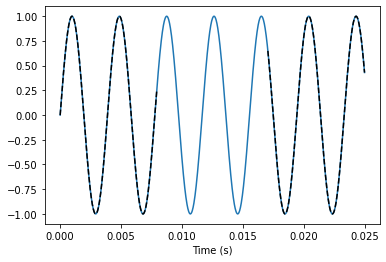

In [87]:
# generate sinusoid
sr = 44e3  # sample rate (Hz)
dt = 1 / sr
t = np.arange(0, 0.025 - dt, dt)  # time
f = 257.4  # frequency
phi0 = 0.0  # initial phase

x = np.sin(2 * np.pi * f * t + phi0)

plt.plot(t, x)
plt.xlabel("Time (s)");

# chop out "missing data"
mididx = int(len(x) / 2)
k = 400
m = mididx - int(k / 2) + 1
choppeddata = np.concatenate((x[:m - 1], x[m + k - 1:]))

plt.plot(t[:m - 1], choppeddata[:m - 1], 'k--')
plt.plot(t[m + k - 1:], choppeddata[m - 1:], 'k--')

In [96]:
# run the Gibbs sampler
chain = gibbs_sampler(choppeddata, m, k, p=80, nsamples=100)

100%|██████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 65.23it/s]


In [90]:
len(t[m + k - 1:])

350

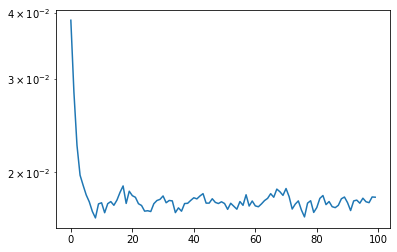

In [97]:
plt.semilogy([s[-1] for s in chain])

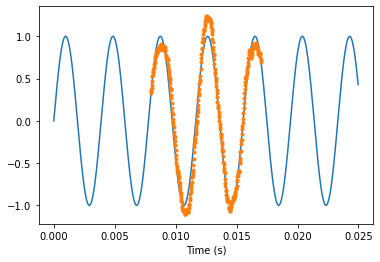

In [98]:
plt.plot(t, x)
plt.xlabel("Time (s)");
plt.plot(t[m - 1:m + k - 1], chain[-1][0], '.')

In [66]:
def thetahat(x, p):
    """
    Calculate the maximum likelihood estimates of the autoregressive
    parameters.
    """

    L = Lmatrix(x, p, full=True)
    invLTL = np.linalg.inv(np.dot(L.T, L))

    # mean
    x0 = np.zeros(len(x) + p)
    x0[:len(x)] = x
    return np.dot(invLTL, np.dot(L.T, x0))


def zhat(theta, y, m, k):
    """
    Calculate the maximum likelihood estimates for the missing
    data, z.
    
    Parameters
    ----------
    theta: array_like
        The set of p autoregressive parameters
    y: array_like
        The observed data.
    m: int
        The index giving the start of the missing samples (starting
        from 1).
    k: int
        The number of missing samples
        
    Returns
    -------
    z: array_like
        A set of k missing samples.
    """

    # total length of data
    N = len(y) + k

    # create K matrix
    K = Kmatrix(theta, N)

    # calculate K^T K
    KTK = np.dot(K.T, K)

    # get the B and D submatrices of KTK
    B = Bmatrix(KTK, m, k)
    D = Dmatrix(KTK, m, k)

    # inverse of D
    invD = np.linalg.inv(D)

    # get the maximum likelihood estimates
    return -np.dot(invD, np.dot(B.T, y))
    

def sigmahat(x, theta):
    """
    Get the maximum likelihood estimate of the noise standard deviation.
    """
    
    N = len(x)

    # calculate "exitation"
    p = len(theta)
    L = Lmatrix(x, p, full=False)
    e = x[p:] - np.dot(L, theta)

    return np.sqrt(np.dot(e.T, e) / N)
    
    
def maximum_likelihood(y, m, k, p, tolerance=1e-8, maxiter=100, init_z=None, seed=None):
    """
    Assuming some data, y, generated from some autoregressive
    process with additive (stationary) Gaussian white noise, and
    a containing a contiguous missing region, find the maximum
    likelihood estimators for the missing samples, autoregressive
    parameters, and noise standard deviation.

    Parameters
    ----------
    y: array_like
        The array of observed data
    m: int
        The index giving the start of the missing samples (starting
        from 1).
    k: int
        The number of missing samples
    p: int
        The order of the autoregressive process. Default is 40.
    tolerance: float
        Relative tolerance for to test for convergence. Default is
        1e-8 absolute tolerance.
    maxiter: int
        The maximum number of iterations to perform. Default is 100.
    init_z: array_like
        Initial guess at autoregression parameters.
    """

    # initialise random number generator
    rng = np.random.default_rng(seed)

    if init_z is None:
        # draw initial values from unit Gaussian if not given
        zprev = rng.normal(size=k)
    else:
        zprev = init_z

    thetaprev = np.zeros(p)
    sigmaprev = np.inf

    # loop until tolerance criteria is fulfilled
    i = 0
    while True:
        print(f"Iteration {i}")
        x = np.concatenate((y[:m - 1], zprev, y[m - 1:]))

        # get maximum likelihood estimate of theta
        thetanew = thetahat(x, p)

        # get maximum likelihood estimate of z
        znew = zhat(thetanew, y, m, k)

        # get maximum likelihood estimate of sigma
        sigmanew = sigmahat(x, thetanew)

        if np.all(
            np.array(
                [
                    np.max(np.abs(thetanew - thetaprev)),
                    np.max(np.abs(znew - zprev)),
                    np.abs(sigmanew - sigmaprev),
                ]
            ) < tolerance
        ) or i > maxiter:
            break
        else:
            sigmaprev = sigmanew
            thetaprev = thetanew
            zprev = znew
   
        i += 1

    return znew, thetanew, sigmanew 

In [81]:
z, theta, sigma = maximum_likelihood(choppeddata, m, k, p=40)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6


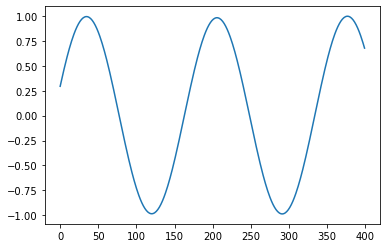

In [82]:
plt.plot(z)

In [83]:
sigma

0.0003959243498264725